In [425]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [426]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm
# from scipy.optimize import curve_fit
# from pathlib import Path
# import pickle

In [427]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [428]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/projects/2017-kohl/OASIS'))
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2

In [429]:
import tensortools as tt

In [430]:
# Import local tools
sys.path.append(os.path.expanduser('~/projects/2017-kohl/repo/'))
from pynalysis import utils

In [431]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tuple of (list, tensor) in which the list contains the indices of valid trials (ie. the ones
    for which the time interval was valid) and the tensor contains the data in format trial x time x unit.
    """
    trials = []
    indices = [] 
    nb_frames = data.shape[0]
    for i,ev in enumerate(event_times):
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
        indices.append(i)
    return indices, np.array(trials)

In [586]:
def load_and_preprocess(area):
    """ Extract and preprocess data from HDF5 file. """
    
    elements = utils.get_hdf5group_keys(area)
    
    planes = []
    for i in range(2):
        planekey = "plane%i"%(i+1)
        if planekey in area.keys():
            planes.append(area[planekey])
    
    sessbehav=area['session_behaviour']
    # print(utils.get_hdf5group_keys(sessbehav))
    
    # Extract frame rate from struct
    frate = area['plane1/fRate'][0,0]
    # print("Frame rate %f"%frate)
    
    fluo = planes[0]['fluoresence_corrected']
    time = np.arange(len(fluo))*1.0/frate
    
    # Extract event timing
#     motor_events = ['motor_start', 'motor_back', 'motor_atWhisk']
#     event_fields = []
#     event_fields.extend(motor_events)
#     event_fields.extend(['velocity', 'stim_position'])
    event_fields = utils.get_hdf5group_keys(sessbehav)
    # event_fields = ['motor_start']

    events = {}
    for f in event_fields:
        events[f] = np.array(sessbehav[f]).ravel()
                
     # tau_d = 270e-3 # GCAMP6M
    # tau_d = 142e-3 # GCAMP6F
    tau_d = 550e-3 # GCAMP6S
    tau_r = 180e-3
    
    AR1=False
    
    if AR1:
        g1 = np.exp(-1.0/(tau_d*frate))
        ginit = (g1,) 
    else:
        g1 = np.exp(-1.0/(tau_d*frate)) + np.exp(-1.0/(tau_r*frate))
        g2 = -np.exp(-1.0/(tau_d*frate))*np.exp(-1.0/(tau_r*frate))
        ginit = (g1,g2) # AR2
    # ginit = (None,)
    # print(ginit)

    plane_data = []
    for plane in planes:
        # Get raw fluoresence
        fluo = np.array(plane['fluoresence_corrected'], dtype=np.float32)
    
        # Extrac cell positions
        tmp = []
        for pos in plane['position']:
            tmp.append(pos)
        positions_plane = np.array(tmp).T

        # Run OASIS on each fluorescence trace   
        traces = []
        spike_trains = []
        # TODO
        ret_values = []
        for idx in range(fluo.shape[1]):
            y = np.array(fluo[:,idx],dtype=float)
            c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
            if np.isnan(c.sum()):
                traces.append(np.zeros(c.shape))
                spike_trains.append(np.zeros(s.shape))
                ret_values.append(r)
            else:
                traces.append(c)
                spike_trains.append(s)
                ret_values.append(r)
        traces = np.array(traces, dtype=np.float32).T
        spike_trains = np.array(spike_trains, dtype=np.float32).T
        
        plane_data.append( dict(fluo=fluo, spikes=spike_trains, traces=traces, pos=pos) )
    
    return time, events, plane_data, frate

In [587]:
def process_hdf_path(hdf5handle, hdf5path, frames_before=15, frames_after=75):
    print("Processing %s -- %s"%(stringid,hdf5path))
    try:
        data = load_and_preprocess(hdf5handle.get(hdf5path))
    except KeyError:
        print("KeyError when preprocessing %s, probably some missing event type?"%hdf5path)
        return
    except TypeError: 
        print("Warning! Could not load %s"%expspecifier)
        return

    
    times, events, plane_data, frate = data

    trigger_times = events['motor_atWhisk']
    # extract velocity
    velocity = events['velocity'].ravel()
    if velocity.max()!=np.abs(velocity).max():
        velocity *= -1
    velocity /= velocity.max()
    valid_indices, trial_velocity = datamatrix2tensor(velocity, 
                          trigger_times, 
                          toff_before=frames_before, 
                          toff_after=frames_after)
    mean_trial_velocity = trial_velocity.mean(1)

    for plane in plane_data:
        # Create data tensor from denoised traces for all trials
        valid_indices, datatensor = datamatrix2tensor(plane["traces"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["datatensor"] = datatensor
        plane["valid_trials"] = valid_indices

        _, fluotensor = datamatrix2tensor(plane["fluo"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["fluotensor"] = fluotensor

        _, spiketensor = datamatrix2tensor(plane["spikes"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["spiketensor"] = spiketensor

        tmp = (datatensor-datatensor.min(0))/(datatensor.std(0)+1.0e-2)
        plane["standardized_trial_data"] = tmp.reshape((tmp.shape[0],-1))


    # extract labels
#     raw_labels = events['stim_position'].ravel()[valid_indices]
#     new_labels = 1*raw_labels
#     for i,l in enumerate(np.unique(raw_labels)):
#         new_labels[new_labels==l] = i
#     labels = new_labels

    result = dict(filename=filename,
                stringid=stringid,
                hdf5path=hdf5path,
                times=times, 
                frate=frate,
                events=events, 
                planes=plane_data, 
                velocity=velocity,
                mean_trial_velocity=mean_trial_velocity,
                # labels=labels,
                )
    
    return result

In [588]:
def get_data_packs(hdf5handle):
    
    data_packs = []
    for day in hdf5handle["imaging"]: 
        for area in dat["imaging"][day]: 
            expspecifier = "%s/%s"%(day,area)
            hdf5path="imaging/%s"%expspecifier
            res = process_hdf_path(hdf5handle, hdf5path)
            if res is not None:
                data_packs.append(res)
        
    return data_packs

In [589]:
# Load data from struct file
stringid="CTBD1.3g"
filename = os.path.expanduser('~//data/kohl/structures/%s.mat'%stringid)
dat = utils.load_mat_file(filename)
packs = get_data_packs(dat)

Processing CTBD1.3g -- imaging/date_2018_06_13/area1
Processing CTBD1.3g -- imaging/date_2018_06_13/area2
Processing CTBD1.3g -- imaging/date_2018_06_22/area1
Processing CTBD1.3g -- imaging/date_2018_06_22/area2
Processing CTBD1.3g -- imaging/date_2018_06_22/area3
Processing CTBD1.3g -- imaging/date_2018_08_04/area1
Processing CTBD1.3g -- imaging/date_2018_08_04/area2
Processing CTBD1.3g -- imaging/date_2018_08_05/area1
Processing CTBD1.3g -- imaging/date_2018_08_05/area2
Processing CTBD1.3g -- imaging/date_2018_08_06/area1
Processing CTBD1.3g -- imaging/date_2018_08_06/area2


In [590]:
pack_depths = [ 120, # 13.6.2018
                180, # 13.6.2018
                120, # 22.6.2018
                180, # 22.6.2018
                300, # 22.6.2018
                130, # 04.8.2018
                220, # 04.8.2018
                220, # 05.8.2018
                130, # 05.8.2018
                130, # 06.8.2018
                220, # 06.8.2018
                # 205, # 03.6.2018
                # 130, # 27.7.2018
                # 200, # 27.7.2018
                # 130, # 03.8.2018
]

print("nb packs %i"%len(packs))
print("nb packs %i"%len(pack_depths))
if len(packs)!=len(pack_depths):
    print("Numbers don't match")
    print(1/0)
    
for dp,depth in zip(packs,pack_depths):
    dp["plane1depth"] = depth

nb packs 11
nb packs 11


In [591]:
pack_dates = [ "13.6.2018",
                "13.6.2018",
                "22.6.2018",
                "22.6.2018",
                "22.6.2018",
                "04.8.2018",
                "04.8.2018",
                "05.8.2018",
                "05.8.2018",
                "06.8.2018",
                "06.8.2018",
                # 205, # "03.6.2018",
                # 130, # "27.7.2018",
                # 200, # "27.7.2018",
                # 130, # "03.8.2018",
]

print("nb packs %i"%len(packs))
print("nb packs %i"%len(pack_dates))
if len(packs)!=len(pack_dates):
    print("Numbers don't match")
    print(1/0)

nb packs 11
nb packs 11


In [438]:
def plot_event(dp,event_name,y_offset=0,**kwargs):
    x = dp["events"][event_name]/dp["frate"]
    y = y_offset*np.ones(len(x))
    plt.scatter(x,y,label=event_name,**kwargs)

In [439]:
def bin_data(data,bs=5):
    """ Bin data along first axis. 
    
    # Args
    data - The data array
    bs - The bin size 
    
    # Returns
    Array with same dimensions as data exept the one which was binned.
    """
    shape = list(data.shape)
    shape[0] = shape[0]//bs 
    binned = np.zeros(shape)
    for b in range(shape[0]):
        binned[b] = data[b*bs:(b+1)*bs].sum(0)
    return binned

def bin_events(dp,event_name,nb_bins=100,bs=5):
    events = np.array(dp["events"][event_name],dtype=int)//bs
    binned = np.zeros(nb_bins)
    for e in events:
        binned[e] += 1
    return binned

In [440]:
def get_trial_labels(dp, trial_times):
    trial_behavior = np.zeros((len(trial_times),5))

    # prep lists
    label_event_names = [ "correct", "missed", "too_soon", "correct_rejection", "false_positive" ]
    evt_lists = [ list(np.array(dp["events"][l], dtype=int)) for l in label_event_names ]
    # print(evt_lists)

    # print(1/0)
    trial_labels = []
    for t in trial_times:
        e = -1
        m = 10000
        for i,lst in enumerate(evt_lists):

            while len(lst) and t>lst[0]: 
                lst.pop(0)

            if len(lst):
                d = lst[0]-t    
                if m>d:
                    m = d
                    e = i

        trial_labels.append(e)
    return np.array(trial_labels)


# Clustering

In [441]:
from sklearn.cluster import KMeans

off = -30

responses = []
psths = []
psths_std = []
plane_membership = []
pack_membership = []
cortical_depth = [] # TODO

for k,dp in enumerate(packs):
    for pl in range(len(dp["planes"])):
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval

        trigger_event_name = "motor_start"
        trial_times = np.array(dp["events"]["motor_start"], dtype=int)

        # chop up data
        duration = 80 # np.min((80,max_dur))
   
        raw = np.array(dp["planes"][pl]["traces"])
        data = []
        labels = []
        for i,t in enumerate(trial_times):
            if t+duration+off>len(raw) or t+off<0: continue
            tmp = raw[t+off:t+off+duration]
            data.append(tmp)
            # labels.append(all_labels[i])
        data = np.array(data)
        psth = data.mean(0)
        psth_std = (psth-psth.min(0))/(100.0+psth.max(0)-psth.min(0))
        # data = (data-data.min(0))/(1.0e-3+data.max(0)-data.min(0))
        
        responses.append(data)
        psths.append(psth)
        psths_std.append(psth_std)
        print(psth.shape)
        n = psth.shape[1]
        plane_membership.append(np.ones(n)*pl)
        pack_membership.append(np.ones(n)*k)
        cortical_depth.append(np.ones(n)*pack_depths[k]+130*pl)
        
        
psths = np.concatenate(psths,axis=1).T
psths_std = np.concatenate(psths_std,axis=1).T

plane_membership = np.concatenate(plane_membership)
pack_membership = np.concatenate(pack_membership)
cortical_depth = np.concatenate(cortical_depth)

(80, 20)
(80, 26)
(80, 55)
(80, 48)
(80, 25)
(80, 22)
(80, 23)
(80, 31)
(80, 18)
(80, 4)
(80, 18)
(80, 23)
(80, 34)
(80, 18)
(80, 42)
(80, 30)
(80, 28)
(80, 35)
(80, 10)
(80, 21)
(80, 33)


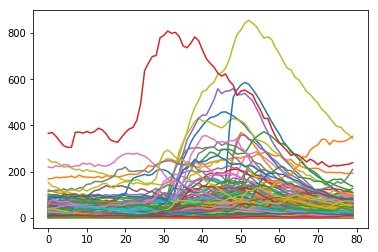

In [442]:
p0=plt.plot(psths.T)

In [443]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(psths_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [444]:
kmeans.cluster_centers_.shape

(7, 80)

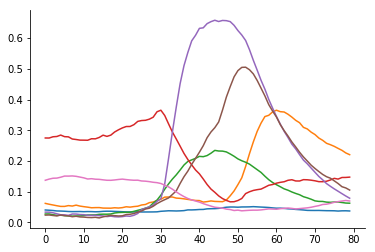

In [445]:
plt.plot(kmeans.cluster_centers_.T)
sns.despine()

In [446]:
pred=kmeans.predict(psths_std)

(array([291.,  42.,   0.,  69.,   0.,  25.,  19.,   0.,  31.,  87.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

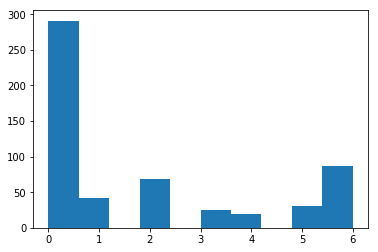

In [447]:
plt.hist(pred)

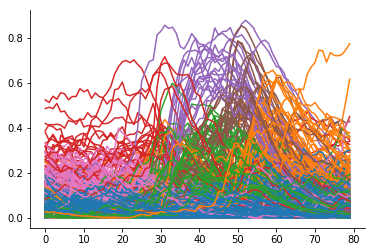

In [448]:
colz=sns.color_palette()
for r,c in zip(psths_std,pred):
    plt.plot(r,color=colz[c])
sns.despine()

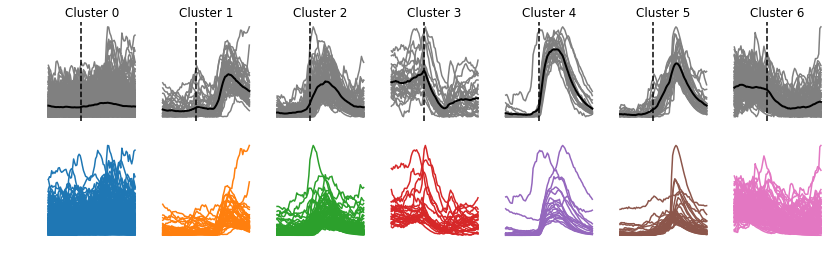

In [449]:
colz=sns.color_palette()
gs = GridSpec(2,kmeans.n_clusters)
fig=plt.figure(figsize=(14,4))

pred=kmeans.predict(psths_std)

for k,p in enumerate(np.unique(pred)):
    ax = plt.subplot(gs[k])
    plt.title("Cluster %i"%k)
    plt.plot(psths_std[pred==p].T,color="gray")
    plt.plot(kmeans.cluster_centers_[k],lw=2,color="black")
    plt.ylabel("Standardized PSTH")
    plt.axvline(-off,linestyle="--",color="black")
    ax.axis("off")
    
for k,p in enumerate(np.unique(pred)):
    ax = plt.subplot(gs[k+kmeans.n_clusters])
    plt.plot(psths[pred==p].T,color=colz[p])
    plt.ylabel("PSTH")
    ax.axis("off")
    
sns.despine()
plt.savefig("plots/centroids.pdf")
plt.savefig("plots/centroids.png")

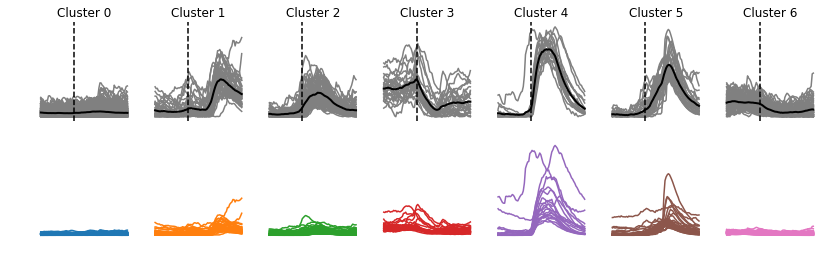

In [450]:
colz=sns.color_palette()
gs = GridSpec(2,kmeans.n_clusters)
fig=plt.figure(figsize=(14,4))

pred=kmeans.predict(psths_std)

for k,p in enumerate(np.unique(pred)):
    if k==0: a0 = ax = plt.subplot(gs[k])
    else: ax = plt.subplot(gs[k], sharey=a0)
    plt.title("Cluster %i"%k)
    plt.plot(psths_std[pred==p].T,color="gray")
    plt.plot(kmeans.cluster_centers_[k],lw=2,color="black")
    plt.axvline(-off,linestyle="--",color="black")
    ax.axis("off")
    
for k,p in enumerate(np.unique(pred)):
    if k==0: a0 = ax = plt.subplot(gs[k+kmeans.n_clusters])
    else: ax = plt.subplot(gs[k+kmeans.n_clusters], sharey=a0)
    plt.plot(psths[pred==p].T,color=colz[p])
    ax.axis("off")
    
sns.despine()
plt.savefig("plots/centroids_samey.pdf")
plt.savefig("plots/centroids_samey.png")

# Analyzing cluster membership

In [451]:
def mkbar(x, off=0.0, normed=False, **kwargs):
    y = [ np.sum(x==i) for i in range(kmeans.n_clusters) ]
    yerr = np.sqrt(y)
    if normed:
        y = np.array(y)
        s = np.sum(y)
        y = y/s
        yerr = yerr/s
    plt.bar(np.arange(kmeans.n_clusters)+off, y, yerr=yerr, **kwargs)
    

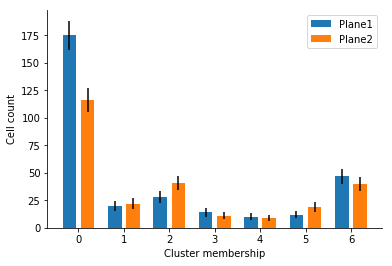

In [452]:
mkbar(pred[plane_membership==0],off=-0.2,width=0.3,label="Plane1")
mkbar(pred[plane_membership==1],off=+0.2,width=0.3,label="Plane2")

plt.xlabel("Cluster membership")
plt.ylabel("Cell count")
plt.legend()
sns.despine()

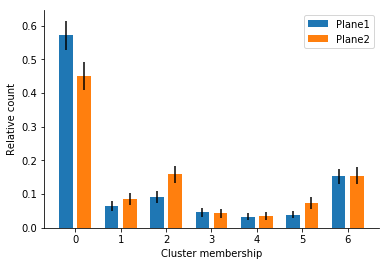

In [453]:
mkbar(pred[plane_membership==0],off=-0.2,width=0.3,label="Plane1", normed=True)
mkbar(pred[plane_membership==1],off=+0.2,width=0.3,label="Plane2", normed=True)

plt.xlabel("Cluster membership")
plt.ylabel("Relative count")
plt.legend()
sns.despine()

# by rounded corctical depth

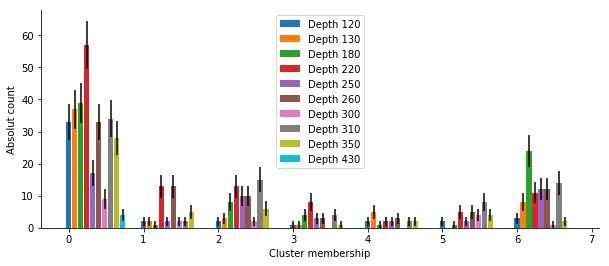

In [454]:
depths = np.unique(cortical_depth)
n = len(depths)
fig=plt.figure(figsize=(10,4))
for k,depth in enumerate(np.unique(depths)):
    tmp = pred[cortical_depth==depth]
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Depth %i"%depth)

plt.xlabel("Cluster membership")
plt.ylabel("Absolut count")
plt.legend()
sns.despine()

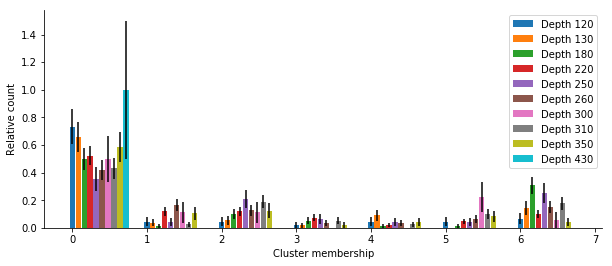

In [455]:
depths = np.unique(cortical_depth)
n = len(depths)
fig=plt.figure(figsize=(10,4))
for k,depth in enumerate(np.unique(depths)):
    tmp = pred[cortical_depth==depth]
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Depth %i"%depth, normed=True)

plt.xlabel("Cluster membership")
plt.ylabel("Relative count")
plt.legend()
sns.despine()

# # by rounded corctical depth

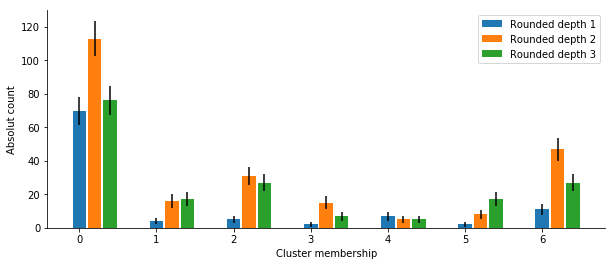

In [456]:
rounded_depth = np.array(np.round(cortical_depth/100))
# print(rounded_depth)
depths = np.unique(rounded_depth)
n = len(depths)
fig=plt.figure(figsize=(10,4))
for k,depth in enumerate(np.unique(depths)[:-1]):
    tmp = pred[rounded_depth==depth]
    mkbar(tmp,off=0.8*(1.0/n*k),width=0.7/n,label="Rounded depth %i"%depth)

plt.xlabel("Cluster membership")
plt.ylabel("Absolut count")
plt.legend()
sns.despine()

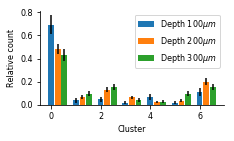

In [457]:
plt.rc('font', size=8)

rounded_depth = np.array(np.round(cortical_depth/100))
# print(rounded_depth)
depths = np.unique(rounded_depth)
n = 3
fig=plt.figure(figsize=(3.3,2))
for k,depth in enumerate(np.unique(depths)[:-1]):
    tmp = pred[rounded_depth==depth]
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Depth $%i\mu m$"%(100*depth), normed=True)

plt.xlabel("Cluster", fontsize=8)
plt.ylabel("Relative count", fontsize=8)
plt.legend(fontsize=8)
plt.tight_layout()
sns.despine()

plt.savefig("plots/histogram.pdf")


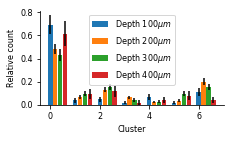

In [458]:
plt.rc('font', size=8)

rounded_depth = np.array(np.round(cortical_depth/100))
# print(rounded_depth)
depths = np.unique(rounded_depth)
n = 4
fig=plt.figure(figsize=(3.3,2))
for k,depth in enumerate(np.unique(depths)):
    tmp = pred[rounded_depth==depth]
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Depth $%i\mu m$"%(100*depth), normed=True)

plt.xlabel("Cluster", fontsize=8)
plt.ylabel("Relative count", fontsize=8)
plt.legend(fontsize=8)
plt.tight_layout()
sns.despine()

plt.savefig("plots/histogram_all.pdf")

##  By plane 1 depth

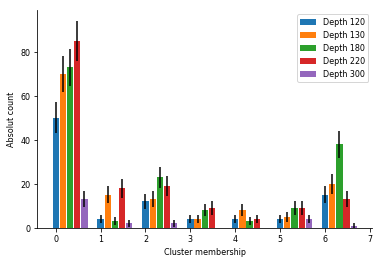

In [459]:
n = len(np.unique(pack_depths))
for k,depth in enumerate(np.unique(pack_depths)):
    idx = np.array(pack_depths)==depth
    pack_ids = np.argwhere(idx).ravel()
    
    tmp = np.concatenate([pred[pack_membership==i] for i in pack_ids])
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Depth %i"%depth)

plt.xlabel("Cluster membership")
plt.ylabel("Absolut count")
plt.legend()
sns.despine()

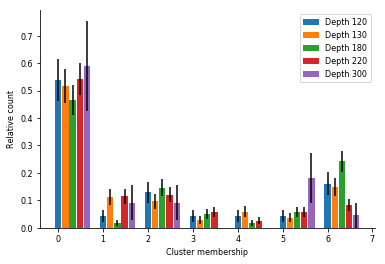

In [460]:
n = len(np.unique(pack_depths))
for k,depth in enumerate(np.unique(pack_depths)):
    idx = np.array(pack_depths)==depth
    pack_ids = np.argwhere(idx).ravel()
    
    tmp = np.concatenate([pred[pack_membership==i] for i in pack_ids])
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Depth %i"%depth, normed=True)

plt.xlabel("Cluster membership")
plt.ylabel("Relative count")
plt.legend()
sns.despine()

##  By date

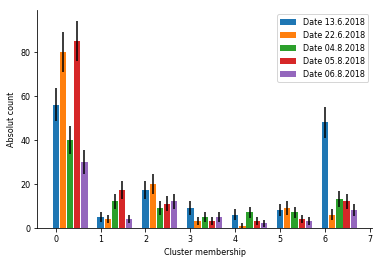

In [461]:
dates = np.unique(pack_dates)
dates = ['13.6.2018', '22.6.2018', '04.8.2018', '05.8.2018', '06.8.2018'] # ordered 
n = len(np.unique(pack_dates))

for k,date in enumerate(dates):
    idx = np.array(pack_dates)==date
    pack_ids = np.argwhere(idx).ravel()
    
    tmp = np.concatenate([pred[pack_membership==i] for i in pack_ids])
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Date %s"%date)

plt.xlabel("Cluster membership")
plt.ylabel("Absolut count")
plt.legend()
sns.despine()

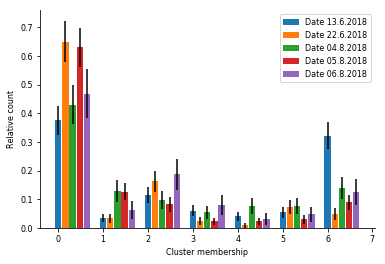

In [462]:
for k,date in enumerate(dates):
    idx = np.array(pack_dates)==date
    pack_ids = np.argwhere(idx).ravel()
    
    tmp = np.concatenate([pred[pack_membership==i] for i in pack_ids])
    mkbar(tmp,off=0.8/n*k,width=0.7/n,label="Date %s"%date,normed=True)

plt.xlabel("Cluster membership")
plt.ylabel("Relative count")
plt.legend()
sns.despine()

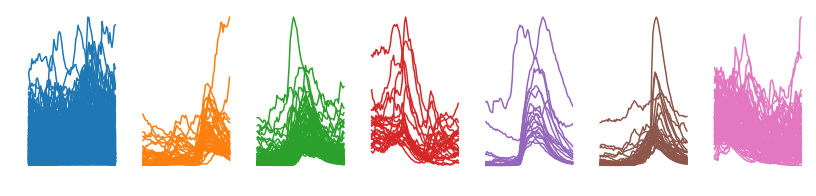

In [463]:
colz=sns.color_palette()
gs = GridSpec(1,kmeans.n_clusters)
fig=plt.figure(figsize=(14,3))
for k,p in enumerate(np.unique(pred)):
    ax = plt.subplot(gs[k])
    plt.plot(psths[pred==p].T,color=colz[p])
    ax.axis("off")
sns.despine()

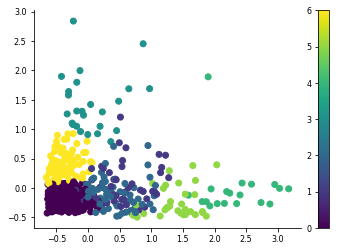

In [464]:
from sklearn.decomposition import PCA
X = psths_std
X_embedded = PCA(n_components=2).fit_transform(X)
X_embedded.shape
colz=sns.color_palette()
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=pred)
plt.colorbar()
sns.despine()

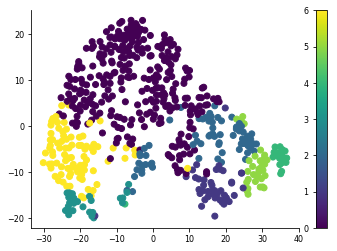

In [465]:
from sklearn.manifold import TSNE
X = psths_std
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape
colz=sns.color_palette()
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=pred)
plt.colorbar()
sns.despine()

# Going back to single trials

In [466]:
a = 0
pred=kmeans.predict(psths_std[pack_membership==a])
pred.shape

(46,)

In [467]:
responses[0].shape
resp = np.concatenate([responses[0],responses[1]],axis=2)
print(resp.shape)

(152, 80, 46)


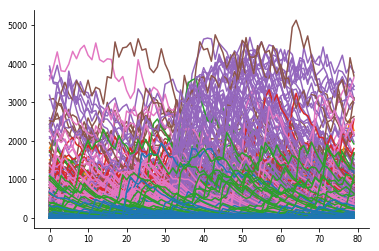

In [468]:
colz=sns.color_palette()
# gs = GridSpec(kmeans.n_clusters,1)
for k,p in enumerate(pred):
    # ax=plt.subplot(gs[k])
    p0=plt.plot(resp[:,:,k].T,color=colz[p])
sns.despine()

(17, 17)
[[ 1.         -0.04776257  0.04392113 -0.07285026 -0.04879152  0.01356477
  -0.02952284 -0.04064324  0.33652994  0.03403213 -0.05680815 -0.08162068
  -0.05611559  0.11384045 -0.06903333 -0.03435035 -0.04852717]
 [-0.04776257  1.         -0.00662075  0.0500265  -0.0353234   0.20125739
   0.20037403 -0.02510969  0.0419596   0.08623938  0.08329479  0.14211471
   0.27311702  0.02336614 -0.06976893 -0.03356412  0.30549971]
 [ 0.04392113 -0.00662075  1.         -0.01276277  0.2023539   0.05529631
  -0.03347851  0.14230225  0.07781648 -0.04699899 -0.01183888 -0.09653541
  -0.0430339  -0.03138718  0.22368001 -0.02116387  0.14901844]
 [-0.07285026  0.0500265  -0.01276277  1.          0.11560254  0.13511797
   0.04649097  0.14249273 -0.08652773  0.07311431 -0.06701227 -0.07123417
   0.10868785 -0.07130006  0.0028317  -0.08819161  0.03046892]
 [-0.04879152 -0.0353234   0.2023539   0.11560254  1.          0.23385648
   0.01208925  0.02192537 -0.05788151 -0.04839942 -0.04097016 -0.11119345

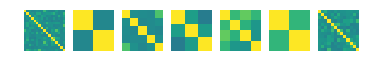

In [469]:
gs = GridSpec(1,kmeans.n_clusters)
for c in range(kmeans.n_clusters):
    idx=pred==c
    if (np.sum(idx)<2): continue
    sel = amp[:,idx]
    # plt.scatter(sel[:,0],sel[:,1])
    C = np.corrcoef(sel.T)
    print(C.shape)
    ax=plt.subplot(gs[c])
    ax.imshow(C,vmin=-1,vmax=1)
    print(C)
    ax.axis("off")
    
# plt.colorbar()

# Supervised classification of trial structure

In [572]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Decoding go trials

In [592]:
x = []
d = []
y = []
yerr = []
chance = []
names = []

days = {}

dps = packs[-6:]
for k,dp in enumerate(dps):
    for pl in range(len(dp["planes"])):
        trigger_event_name = "motor_start"
        trial_times = np.array(dp["events"]["motor_start"], dtype=int)
        
        
        # compute labels
        trial_labels = get_trial_labels(dp, trial_times)
        all_labels = np.array([ l in [0,1,2] for l in trial_labels ], dtype=int) # Go trials
        # all_labels = np.array([ l in [0,3] for l in trial_labels ], dtype=int) # Go trials
        
        # chop up data
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval
        duration = np.min((60,max_dur))
        off = -10
        raw = np.array(dp["planes"][pl]["traces"])
        data = []
        labels = []
        for i,t in enumerate(trial_times):
            if t+duration+off>len(raw) or t+off<0: continue
            # tmp = raw[t+off:t+duration+off].mean(axis=0)
            tmp = np.concatenate((raw[t+off:t].mean(axis=0),raw[t:t+duration+off].mean(axis=0)))
            # tmp = raw[t:t+duration].ravel()
            data.append(tmp)
            labels.append(all_labels[i])
        data = np.array(data)

        # preprocess/standardize data
        data = (data-np.min(data,0))/(np.max(data,0)-np.min(data,0)+1e-7)

       
        # print(len(labels))

        # fit and evaluate binary classifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)   
        scores = cross_val_score(clf, data, labels, cv=5)

        print("pack %i: %s"%(k,dp["hdf5path"]))
        print("Mean score %f+-%f"%(np.mean(scores),2*np.std(scores)))
        p = np.mean(labels)
        ch = np.max((p,1.0-p))
        print("Chance %f"%ch)

        x.append(k+0.1*pl)
        d.append(dp["plane1depth"]+pl*130)
        y.append(np.mean(scores))
        yerr.append(np.std(scores))
        chance.append(ch)
        names.append(dp['hdf5path'])

pack 0: imaging/date_2018_08_04/area1
Mean score 0.880000+-0.233238
Chance 0.686275
pack 0: imaging/date_2018_08_04/area1
Mean score 0.689091+-0.163191
Chance 0.686275
pack 1: imaging/date_2018_08_04/area2
Mean score 0.724825+-0.036977
Chance 0.724138
pack 1: imaging/date_2018_08_04/area2
Mean score 0.847786+-0.195613
Chance 0.724138
pack 2: imaging/date_2018_08_05/area1
Mean score 0.896970+-0.141933
Chance 0.551020
pack 2: imaging/date_2018_08_05/area1
Mean score 0.959596+-0.099791
Chance 0.551020
pack 3: imaging/date_2018_08_05/area2
Mean score 0.682540+-0.194663
Chance 0.558140
pack 3: imaging/date_2018_08_05/area2
Mean score 0.904762+-0.171546
Chance 0.558140
pack 4: imaging/date_2018_08_06/area1
Mean score 0.745758+-0.284709
Chance 0.563636
pack 4: imaging/date_2018_08_06/area1
Mean score 0.876970+-0.222635
Chance 0.563636
pack 5: imaging/date_2018_08_06/area2
Mean score 0.909091+-0.114992
Chance 0.553571


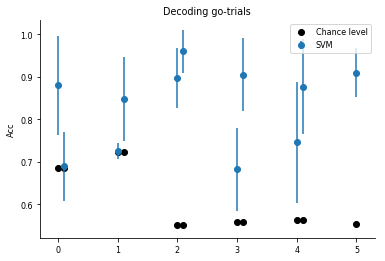

In [593]:
plt.title("Decoding go-trials")
plt.errorbar(x,y,yerr=yerr,fmt="o", label="SVM")
plt.scatter(x,[chance],color="black", label="Chance level")

plt.ylabel("Acc")
plt.legend()
sns.despine()

2018_08_04
imaging/date_2018_08_04/area1
imaging/date_2018_08_04/area1
imaging/date_2018_08_04/area2
imaging/date_2018_08_04/area2
2018_08_05
imaging/date_2018_08_05/area1
imaging/date_2018_08_05/area1
imaging/date_2018_08_05/area2
imaging/date_2018_08_05/area2
2018_08_06
imaging/date_2018_08_06/area1
imaging/date_2018_08_06/area1
imaging/date_2018_08_06/area2


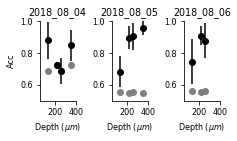

In [594]:
gs = GridSpec(1,3)
fig=plt.figure(figsize=(3.3,2))

dates = [ x[13:-6] for x in names ]
for i,date in enumerate(np.unique(dates)):
    print(date)
    ax=plt.subplot(gs[i])
    if i==0: plt.ylabel("Acc")
    for k,name in enumerate(names):
        if date in name:
            print(name)
            ax.errorbar(d[k], y[k], yerr=yerr[k], fmt="o", label="SVM", color="black")
            ax.scatter(d[k],chance[k], color="gray", label="Chance")
            ax.set_title(date)
            ax.set_ylim(0.5,1.0)
            ax.set_xlim(50,400)
            ax.set_xlabel("Depth ($\mu m$)")
            
sns.despine()
# plt.legend()
plt.tight_layout()
plt.savefig("plots/depth_vs_acc.pdf")
plt.savefig("plots/depth_vs_acc.png")

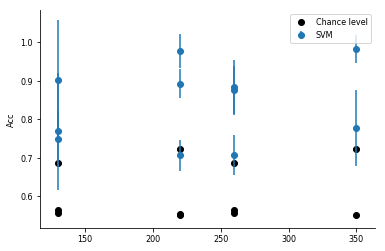

In [585]:

plt.errorbar(d,y,yerr=yerr,fmt="o", label="SVM")
plt.scatter(d,[chance],color="black", label="Chance level")
plt.ylabel("Acc")
plt.legend()
sns.despine()